[   0.   25.   50.   75.  100.  125.  150.  175.  200.  225.  250.  275.
  300.  325.  350.  375.  400.  425.  450.  475.  500.  525.  550.  575.
  600.  625.  650.  675.  700.  725.  750.  775.  800.  825.  850.  875.
  900.  925.  950.  975. 1000. 1025. 1050. 1075. 1100. 1125. 1150. 1175.
 1200. 1225. 1250. 1275. 1300. 1325. 1350. 1375. 1400. 1425. 1450. 1475.
 1500. 1525. 1550. 1575. 1600. 1625. 1650. 1675. 1700. 1725. 1750. 1775.
 1800. 1825. 1850. 1875. 1900. 1925. 1950. 1975. 2000. 2025. 2050. 2075.
 2100. 2125. 2150. 2175. 2200. 2225. 2250. 2275. 2300. 2325. 2350. 2375.
 2400. 2425. 2450. 2475. 2500. 2525. 2550. 2575. 2600. 2625. 2650. 2675.
 2700. 2725. 2750. 2775. 2800. 2825. 2850. 2875. 2900. 2925. 2950. 2975.]
Step number 1 of 120
stim off.
trial number 1
Step number 2 of 120
stim off.
trial number 1
Step number 3 of 120
stim off.
trial number 1
Step number 4 of 120
stim off.
trial number 1
Step number 5 of 120
stim off.
trial number 1
Step number 6 of 120
stim off.
trial nu

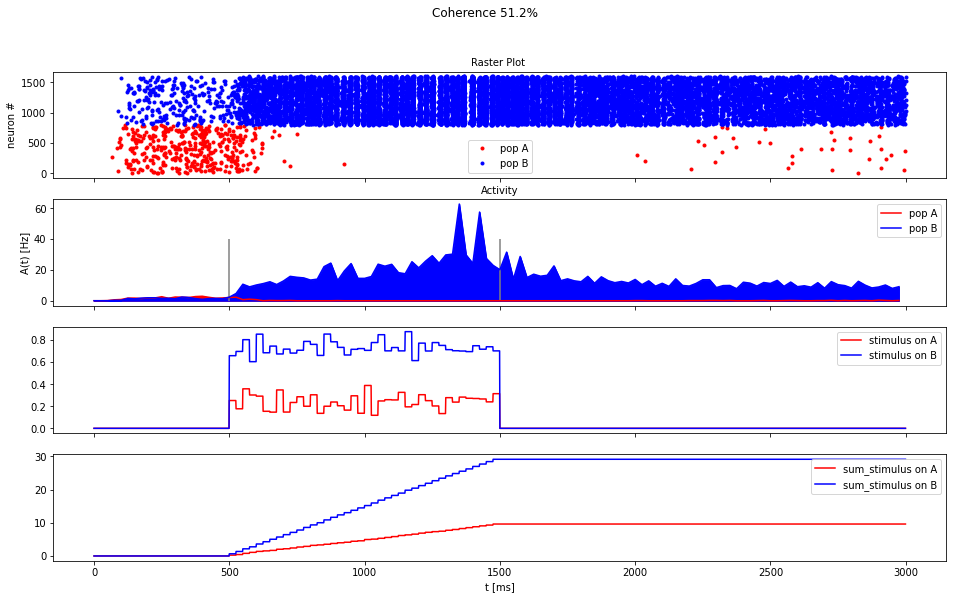

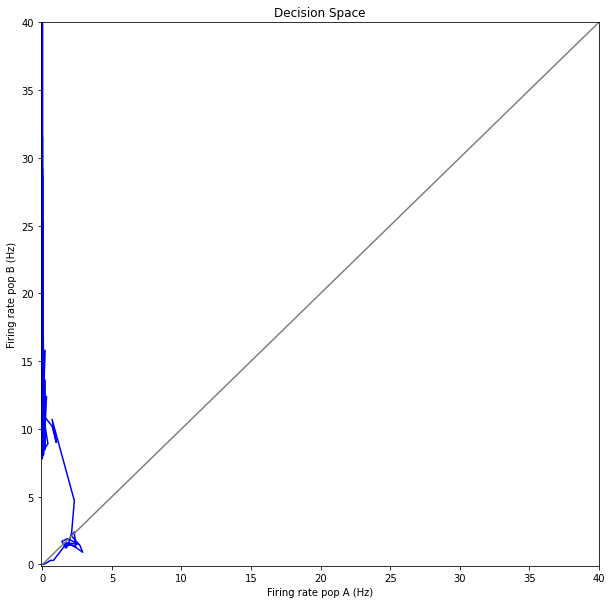

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nest
import nest.raster_plot
import os
from simulate_network import *

nest.ResetKernel()
dt = 0.1
dt_rec = 10.0
nest.SetKernelStatus({"resolution": dt, "print_time": True, "overwrite_files": True})
t0 = nest.GetKernelStatus('time')

save = False
notes = 'C_0-0_'
coherence = 0.512
order = 400
simtime = 3000.0
start_stim = 500.0
end_stim = 1500.0
current_path = os.getcwd()+'/'
n_run=1



nest.ResetKernel()
results, stimulus_A, stimulus_B, noise_A, noise_B, sum_stimulus_A, sum_stimulus_B = simulate_network(n_run, coherence, order , start_stim , end_stim , simtime)     

#TODO find optimal par std and mean for stimulus and std for noise
smA = nest.GetStatus(results["spike_monitor_A"])[0]
rmA = nest.GetStatus(results["rate_monitor_A"])[0]	
smB = nest.GetStatus(results["spike_monitor_B"])[0]
rmB = nest.GetStatus(results["rate_monitor_B"])[0]
fig = None
ax_raster = None
ax_rate = None
fig, (ax_raster, ax_rate, ax_stimuli, ax_sum_stimuli) = plt.subplots(4, 1, sharex=True, figsize=(16,9))
plt.suptitle('Coherence ' + str(coherence*100) + '%')
evsA = smA["events"]["senders"]
tsA = smA["events"]["times"]
ax_raster.plot(tsA, evsA, ".", color='red', label ='pop A')
evsB = smB["events"]["senders"]
tsB = smB["events"]["times"]
ax_raster.plot(tsB, evsB, ".", color='blue', label ='pop B')
ax_raster.set_ylabel("neuron #")
ax_raster.set_title("Raster Plot ", fontsize=10)
ax_raster.legend()
t = np.arange(0., simtime, dt_rec)
A_N_A = np.ones((t.size, 1)) * np.nan
trmA = rmA["events"]["times"]
trmA = trmA * dt - t0
bins = np.concatenate((t, np.array([t[-1] + dt_rec])))
A_N_A = np.histogram(trmA, bins=bins)[0] / order / dt_rec
ax_rate.plot(t, A_N_A * 1000, color='red', label ='pop A')
ax_rate.fill_between(t, A_N_A * 1000, color='red')
B_N_B = np.ones((t.size, 1)) * np.nan
trmB = rmB["events"]["times"]
trmB = trmB * dt - t0
bins = np.concatenate((t, np.array([t[-1] + dt_rec])))
B_N_B = np.histogram(trmB, bins=bins)[0] / order / dt_rec
ax_rate.plot(t, B_N_B * 1000, color='blue', label ='pop B')
ax_rate.fill_between(t, B_N_B * 1000, color='blue')
ax_rate.vlines(start_stim, 0, 40, color='grey')
ax_rate.vlines(end_stim, 0, 40, color='grey')
ax_rate.set_ylabel("A(t) [Hz]")
ax_rate.set_title("Activity", fontsize=10)
ax_rate.legend()
ax_stimuli.plot(np.arange(0., simtime),stimulus_A, 'red', label='stimulus on A')
ax_stimuli.plot(np.arange(0., simtime),stimulus_B, 'blue', label='stimulus on B')
ax_stimuli.legend()
plt.xlabel("t [ms]")

ax_sum_stimuli.plot(np.arange(0., simtime),sum_stimulus_A, 'red', label='sum_stimulus on A')
ax_sum_stimuli.plot(np.arange(0., simtime),sum_stimulus_B, 'blue', label='sum_stimulus on B')
ax_sum_stimuli.legend()
plt.xlabel("t [ms]")

decisional_space = plt.figure(figsize = [10,10])
if np.mean(A_N_A*1000)>np.mean(B_N_B*1000):
    c='red'
    winner = 'pop_A'
else:
    winner = 'pop_B'
    c='blue'
plt.plot(A_N_A * 1000,B_N_B * 1000, color=c)
plt.plot([0,40],[0,40], color='grey')
plt.xlim(-0.1,40)
plt.ylim(-0.1,40)
plt.xlabel("Firing rate pop A (Hz)")
plt.ylabel("Firing rate pop B (Hz)")
plt.title("Decision Space")
plt.show()


if save:
    saving_dir = 'results/'+notes+winner+'/'
    if not os.path.exists(saving_dir):
        os.makedirs(saving_dir)

    fig.savefig(saving_dir+notes+winner+'raster_activity_stimuli.eps' , bbox_inches='tight')
    decisional_space.savefig(saving_dir+notes+winner+'decision_space.eps' , bbox_inches='tight')
    raster_A = {'ID neuron pop_A':evsA, 'event time pop_A':tsA}
    raster_B = { 'ID neuron pop_B':evsB, 'event time pop_B':tsB}
    activity = {'time':t,'activity (Hz) pop_A': A_N_A*1000, 'activity (Hz) pop_B': B_N_B*1000}
    stimuli = {'stimulus pop A': stimulus_A,'stimulus pop B': stimulus_B}
    events_A = pd.DataFrame(raster_A)
    events_B = pd.DataFrame(raster_B)
    frequency = pd.DataFrame(activity)
    stimuli = pd.DataFrame(stimuli)
    events_A.to_csv(saving_dir+notes+'events_pop_A.csv')
    events_B.to_csv(saving_dir+notes+'events_pop_B.csv')
    frequency.to_csv(saving_dir+notes+'frequency.csv')
    stimuli.to_csv(saving_dir+notes+'stimuli.csv')
